In [ ]:
# --------------------------------
# Name: mixing_length.ipynb
# Author: Brian R. Greene
# University of Oklahoma
# Created: 1 November 2021
# Purpose: calculate profiles of mixing length and output
# ascii files for further analysis
# --------------------------------

In [1]:
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [2]:
# user directories
fsim = "/home/bgreene/simulations/"
dsave = "/home/bgreene/SBL_LES/output/"
sims = ["A", "B", "C", "D", "E", "F"]
# load data and store in list
s_all = []
for s in sims:
    dat = xr.load_dataset(f"{fsim}{s}_192_interp/output/netcdf/average_statistics.nc")
    s_all.append(dat)

In [3]:
# calculate ustar and du_dz and store back in each xarray
for s in s_all:
    # ustar and ustar^2 for h
    s["ustar"] = ((s.uw_cov_tot**2.) + (s.vw_cov_tot**2.)) ** 0.25
    s["ustar2"] = s.ustar ** 2.
    # h
    s["h"] = s.z.where(s.ustar2 <= 0.05*s.ustar2[0], drop=True)[0]/0.95
    # grab z values <= h and crete new array of z/h
    isbl = np.where(s.z <= s.h)[0]
    s["isbl"] = isbl
    z_h = s.z / s.h
    s["z_h"] = z_h.isel(z=isbl)
    # du_dz ROTATED
    s["du_dz2"] = s.u_mean_rot.differentiate("z")
    # sqrt((du_dz**2) + (dv_dz**2))
    s["du_dz"] = np.sqrt(s.u_mean.differentiate("z", 2)**2. + s.v_mean.differentiate("z", 2)**2.)
    # lm = ustar/du_dz
    s["lm"] = (s.ustar / abs(s.du_dz)).isel(z=isbl)
    s["lm2"] = (s.ustar / abs(s.du_dz2)).isel(z=isbl)
    # calculate Local Obukhov length L
    L = -(s.ustar**3.) * s.theta_mean.isel(z=0) / (0.4 * 9.81 * s.tw_cov_tot)
    s["L"] = L.isel(z=isbl)
    # calculate gradient Richardson number
    # Ri = N^2 / S^2
    N2 = s.theta_mean.differentiate("z", 2) * 9.81 / s.theta_mean.isel(z=0)
    s["Ri"] = N2 / s.du_dz / s.du_dz
    # calculate gradient scales from Sorbjan 2017, Greene et al. 2022
    l0 = 19.22 # m
    l1 = 1./(s.Ri**(3./2.))
    kz = 0.4 * s.z.isel(z=isbl)
    s["Ls"] = kz / (1 + (kz/l0) + (kz/l1))
    s["Us"] = s.Ls * np.sqrt(N2)
    s["Ts"] = s.Ls * s.theta_mean.differentiate("z", 2)

(0.0, 4.0)

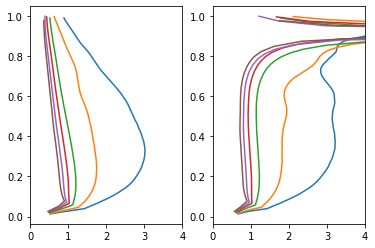

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for s in s_all:
    ax[0].plot(s.lm, s.z_h)
    ax[1].plot(s.lm2, s.z_h)
# ax.set_ylim([0, 1])
ax[0].set_xlim([0, 4])
ax[1].set_xlim([0, 4])

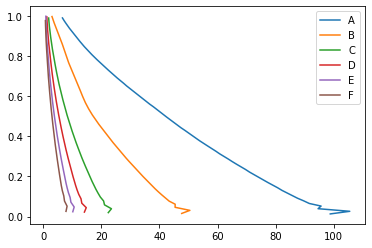

In [5]:
fig1, ax1 = plt.subplots(1)
for s in s_all:
    ax1.plot(s.L, s.z_h, label=s.stability)
ax1.legend()

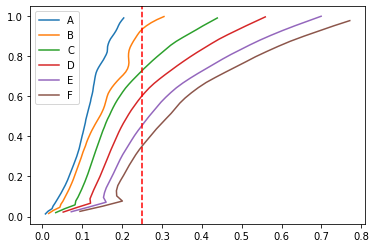

In [6]:
fig2, ax2 = plt.subplots(1)
for s in s_all:
    ax2.plot(s.Ri, s.z_h, label=s.stability)
ax2.legend()
ax2.axvline(0.25, c="r", ls="--")

Text(0.5, 0, '$T_s$ [K]')

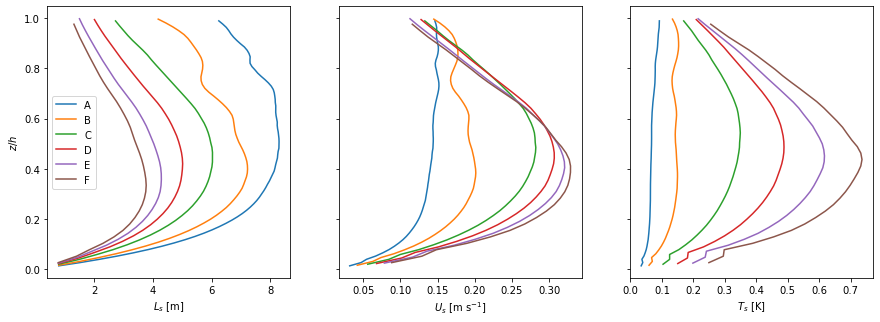

In [7]:
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8,5))
for s in s_all:
    ax3[0].plot(s.Ls, s.z_h, label=s.stability)
    ax3[1].plot(s.Us, s.z_h, label=s.stability)
    # ax3[1].plot(s.ustar, s.z_h, ls="--", label=s.stability)
    ax3[2].plot(s.Ts, s.z_h, label=s.stability)
ax3[0].legend()
ax3[0].set_ylabel("$z/h$")
ax3[0].set_xlabel("$L_s$ [m]")
ax3[1].set_xlabel("$U_s$ [m s$^{-1}$]")
ax3[2].set_xlabel("$T_s$ [K]")

In [8]:
for s in s_all:
    print(s.z.isel(z=s.Ls.argmax()).values)

80.83551483420594
53.893979057591636
49.749127399650966
39.38699825479931
31.09729493891798
26.952443280977317


In [9]:
# save csv files with z, z/h, lm, L
for s in s_all:
    fsave = f"{dsave}{s.stability}_mixing_lengths.csv"
    data_out = np.c_[s.z.isel(z=s.isbl), s.z_h.isel(z=s.isbl), s.lm.isel(z=s.isbl), s.L.isel(z=s.isbl), s.Ri.isel(z=s.isbl)]
    headers = "z(m), z/h, l_m(m), L(m), Ri"
    np.savetxt(fsave, data_out, fmt=["%4.3f", "%4.3f", "%4.3f", "%4.3f", "%4.3f"], header=headers,
               comments="", delimiter=",")

In [10]:
data_out

array([[2.08333333e+00, 2.58071398e-02, 4.68669221e-01, 7.80897317e+00,
        9.43879491e-02],
       [4.15575916e+00, 5.14791637e-02, 7.50170890e-01, 8.18078337e+00,
        1.51137437e-01],
       [6.22818499e+00, 7.71511876e-02, 8.98327933e-01, 7.29328527e+00,
        2.00718515e-01],
       [8.30061082e+00, 1.02823211e-01, 8.45173098e-01, 7.04461571e+00,
        1.86493046e-01],
       [1.03730366e+01, 1.28495235e-01, 8.11216485e-01, 6.55296447e+00,
        1.85727927e-01],
       [1.24454625e+01, 1.54167259e-01, 7.88980635e-01, 6.19331698e+00,
        1.89193232e-01],
       [1.45178883e+01, 1.79839283e-01, 7.76159089e-01, 5.88939667e+00,
        1.96154037e-01],
       [1.65903141e+01, 2.05511307e-01, 7.65525636e-01, 5.61821340e+00,
        2.03824532e-01],
       [1.86627400e+01, 2.31183331e-01, 7.51799689e-01, 5.34081608e+00,
        2.11010361e-01],
       [2.07351658e+01, 2.56855355e-01, 7.37284893e-01, 5.07782735e+00,
        2.18231010e-01],
       [2.28075916e+01, 2.8252

In [68]:
# make sure differentiate function works right
u = s_all[0].u_mean_rot
z = s_all[0].z
dz = s_all[0].dz

du_dz = np.zeros(u.z.size, dtype=np.float64)
for i in range(1,u.z.size-1):
    du = u.isel(z=i+1) - u.isel(z=i-1)
    du_dz[i] = (du/dz/2)

du_dz_xr1 = u.differentiate("z", 1)
du_dz_xr2 = u.differentiate("z", 2)

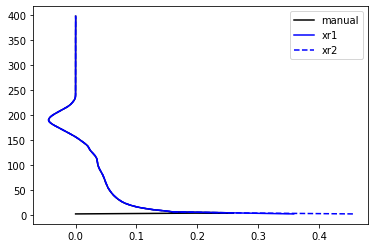

In [69]:
fig1, ax1 = plt.subplots(1)
ax1.plot(du_dz, z, "-k", label="manual")
ax1.plot(du_dz_xr1, z, "-b", label="xr1")
ax1.plot(du_dz_xr2, z, "--b", label="xr2")
ax1.legend()

# Plot u/ustar vs z/h semilog profile

Text(0, 0.5, '$\\langle u \\rangle / u_*$')

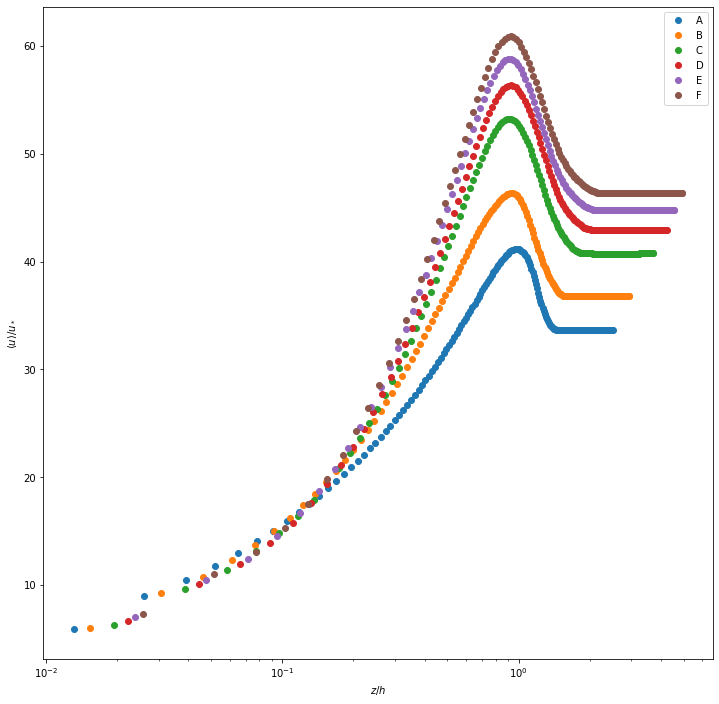

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 12))

for s in s_all:
    ax.plot(s.z/s.h, s.u_mean_rot/s.ustar.isel(z=0), "o", label=s.stability)

ax.legend()
ax.set_xscale("log")
ax.set_xlabel("$z/h$")
ax.set_ylabel("$\\langle u \\rangle / u_*$")